## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

In [1]:
!pip install swifter
!pip install textblob
!pip install wordcloud

## Importing the necessary libraries

In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
import swifter 
from textblob import TextBlob
from nltk import word_tokenize, pos_tag
from wordcloud import WordCloud, STOPWORDS

from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import naive_bayes # .MultinomialNB
from sklearn.naive_bayes import MultinomialNB

import warnings

# Suppress all warnings globally
warnings.filterwarnings("ignore")

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [5]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [6]:
#print the column names
column_list = df.columns
column_list

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
#Assign new column names
for col in column_list:
    val = col.replace('_','')
    val = val.replace('source.','')
    df.rename(columns={col: val}, inplace=True)

In [8]:
df.rename(columns={'complaintid': 'complaint_id',
                  'datereceived':'received_date',
                  'companyresponse':'company_response',
                  'submittedvia':'submittion_mode',
                  'datesenttocompany':'sent_date',
                  'companypublicresponse':'company_response',
                  'complaintwhathappened':'complaints',
                  'subissue':'sub_issue',
                  'consumerconsentprovided':'consumer_consent_provided'}, inplace=True)

In [9]:
 df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zipcode', 'complaint_id',
       'issue', 'received_date', 'state', 'consumerdisputed', 'product',
       'company_response', 'company', 'submittion_mode', 'sent_date',
       'company_response', 'subproduct', 'timely', 'complaints', 'sub_issue',
       'consumer_consent_provided'],
      dtype='object')

In [10]:
#Assign nan in place of blanks in the complaints column
df['complaints'] = df['complaints'].replace(r'^\s*$', np.nan, regex=True)

In [11]:
df['complaints'].head()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           NaN
1    Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.
2       

In [12]:
#Remove all rows where complaints column is nan
print('shape before NaN rows removal', df.shape)
df.dropna(subset=['complaints'],inplace=True)
print('shape after NaN rows removal', df.shape)

shape before NaN rows removal (78313, 22)
shape after NaN rows removal (21072, 22)


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [13]:
# Write your function here to clean the text and remove all the unnecessary elements.
def data_formate(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation) ,'',text)
    text = re.sub(r'\w*\d\w*','',text)
    return text

In [14]:
df['complaints'] = df['complaints'].apply(data_formate)

In [15]:
# loading spacy model
spacy_nlp_model = spacy.load('en_core_web_sm',exclude=['ner'])

In [16]:
#Write your function to Lemmatize the texts

lemma = []
nouns = []

for doc in spacy_nlp_model.pipe(df['complaints'].values, n_process=-1):
    if doc.has_annotation('DEP'):
        lemma_sentence = [token.lemma_ for token in doc]
        nouns_sentence = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
        lemma.append(" ".join(lemma_sentence)) 
        nouns.append(" ".join(nouns_sentence))
    else:
        lemma.append(None)
        nouns.append(None)


In [17]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df['lemmatized complaints'] =  lemma
df['lemmatized complaints'].head(10)

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [18]:
df_clean = df[['complaints' , 'lemmatized complaints']].copy()
df_clean.head()

,complaints,lemmatized complaints
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny but she could not state why I as

In [19]:
#Write your function to extract the POS tags 

df_clean["complaint_POS_removed"] =  nouns
df_clean["complaint_POS_removed"].head(10)

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        morning name stop bank cardmember service debt verification statement bank debt

In [20]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(10)

,complaints,lemmatized complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account xxxx thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx card agent anniversary date agent information order account anniversary date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the off

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




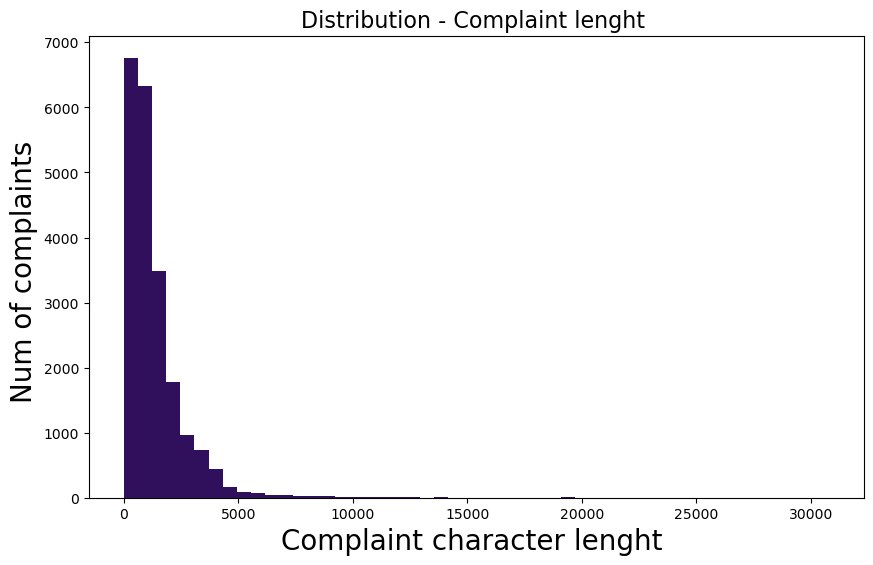

In [21]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean["complaint_length"] = df_clean["complaints"].apply(len)

fig = plt.figure(figsize=(10,6))

plt.hist(df_clean['complaint_length'],bins=50,color='#30105C')

plt.title('Distribution - Complaint lenght ', fontsize=16)
plt.ylabel('Num of complaints ', fontsize=20)
plt.xlabel('Complaint character lenght ', fontsize=20)

plt.show()


#### Find the top 40 words by frequency among all the articles after processing the text.

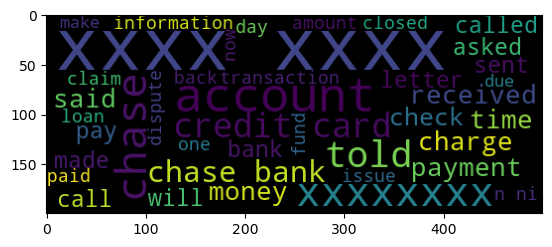

In [22]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_words=40,background_color='black',stopwords=stopwords,width=500,height=200).generate(str(df_clean['complaints']))
plt.imshow(wordcloud)
plt.show()

In [23]:
#Removing -PRON- from the text corpus

def remove_pronouns(text):
    # Process the text using the NLP model
    doc = nlp(text)
    
    # Initialize a list to hold tokens that are not pronouns
    filtered_tokens = []
    
    # Iterate through each token in the processed text
    for token in doc:
        # Check if the token is not a pronoun
        if token.pos_ != "PRON":
            # Append the token's text to the list
            filtered_tokens.append(token.text)
    
    # Join the list of filtered tokens back into a single string
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text

df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].swifter.apply(remove_pronouns)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [24]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

def get_top_ngram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

def create_ngram_barplot(data, column='unigram', count=10):
    df1 = pd.DataFrame(data, columns = [column , 'count'])
    plt.figure(figsize=(12,6))
    fig = sns.barplot(x=df1[column], y=df1['count'],palette="Blues_d")
    plt.xticks(rotation=90)
    plt.title(f"Top {count} {column} in the Complaint text after removing stop words and lemmatization", fontsize=20)
    plt.show()

In [25]:
top_30_unigrams = get_top_ngram(df_clean.Complaint_clean,ngram=1, top=30)
top_30_bigrams = get_top_ngram(df_clean.Complaint_clean,ngram=2, top=30)
top_30_trigrams = get_top_ngram(df_clean.Complaint_clean,ngram=3, top=30)

In [26]:
top_10_unigrams = get_top_ngram(df_clean.Complaint_clean,ngram=1, top=10)
top_10_bigrams = get_top_ngram(df_clean.Complaint_clean,ngram=2, top=10)
top_10_trigrams = get_top_ngram(df_clean.Complaint_clean,ngram=3, top=10)

,unigram,count
0,chase,53085
1,account,46176
2,xxxx,43441
3,credit,32599
4,card,30231
5,bank,21481
6,payment,21157
7,time,16002
8,day,12972
9,charge,11983


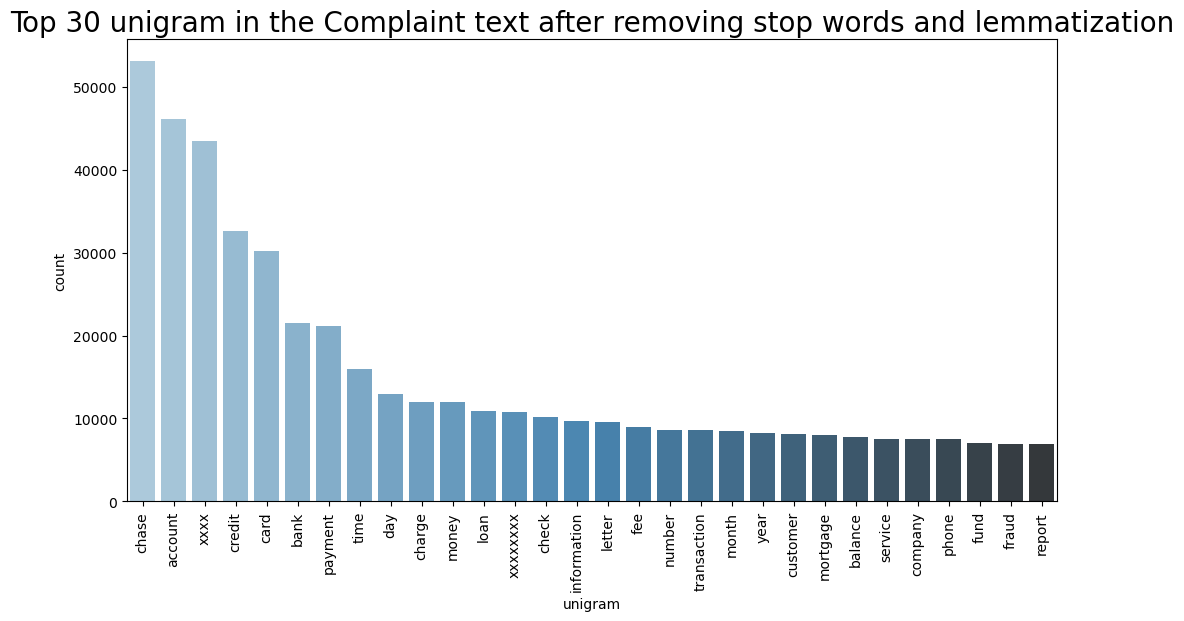

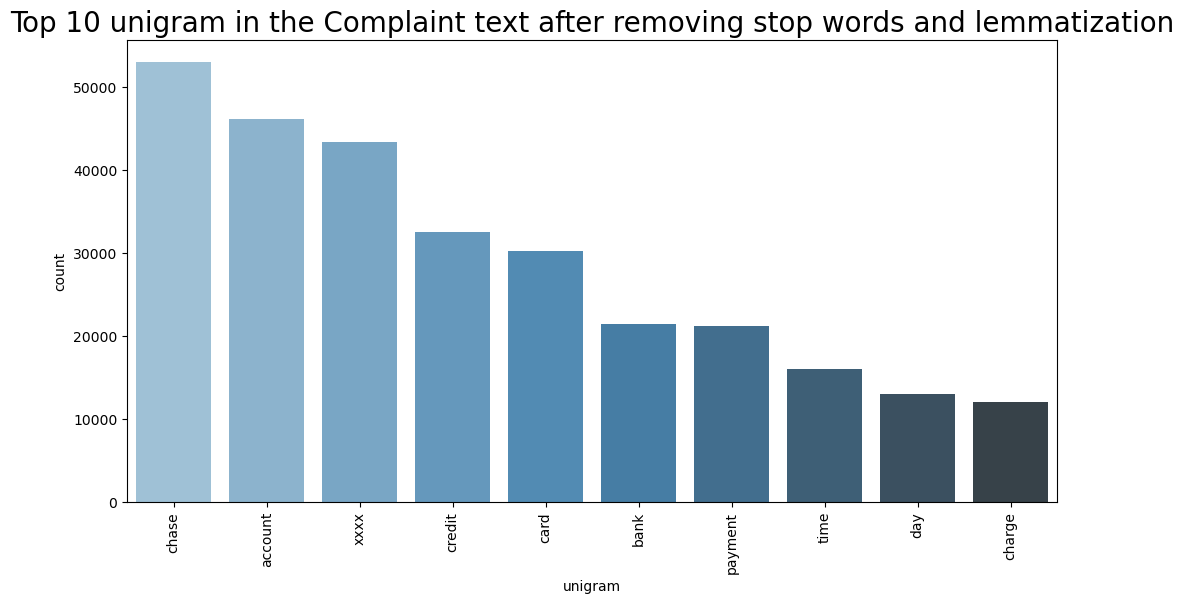

In [27]:
#Print the top 30 words in the unigram frequency
df_unigram = pd.DataFrame(top_30_unigrams[:30], columns = ['unigram' , 'count'])
display(df_unigram.head(30))

#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

create_ngram_barplot(top_30_unigrams, column='unigram', count=30)

create_ngram_barplot(top_10_unigrams, column='unigram', count=10)

,bigram,count
0,credit card,12852
1,xxxx xxxx,4561
2,credit report,3843
3,account chase,3167
4,customer service,3065
5,chase credit,2974
6,chase account,2930
7,account account,2586
8,bank account,2495
9,chase bank,2113


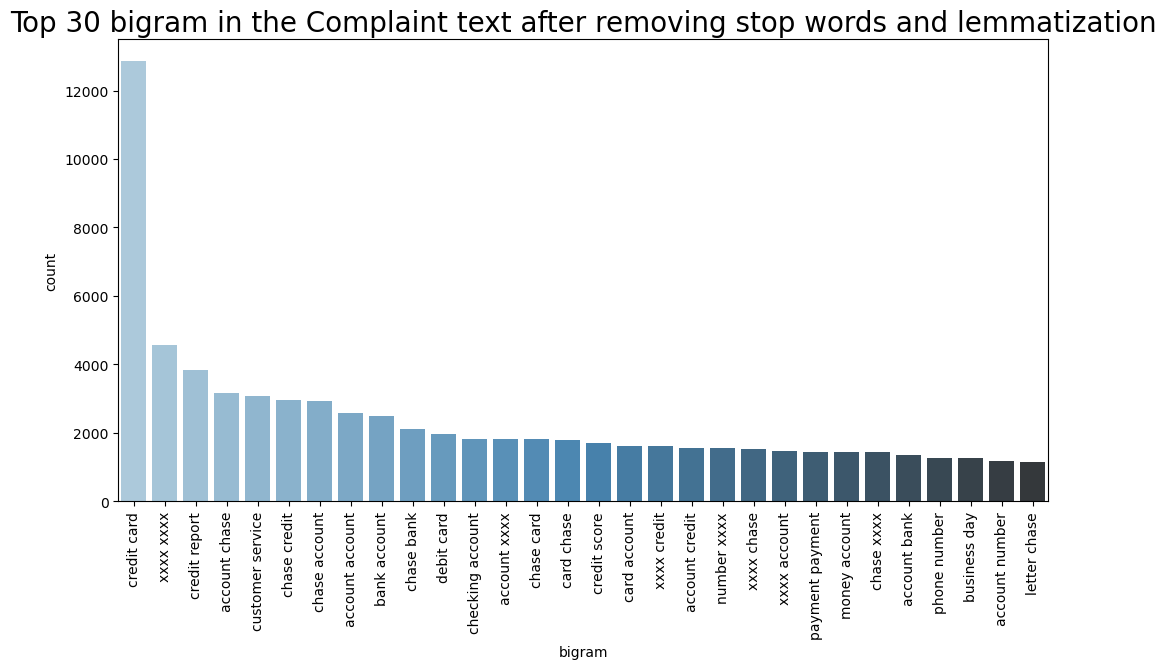

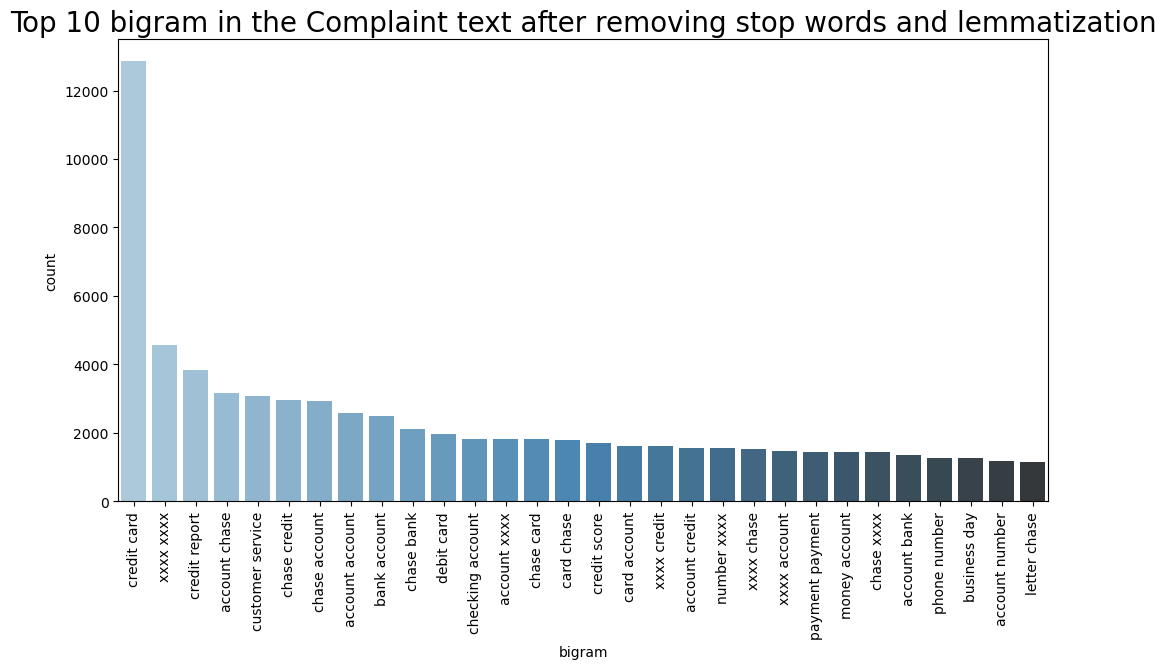

In [28]:
#Print the top 30 words in the bigram frequency
df_bigram = pd.DataFrame(top_30_bigrams[:30], columns = ['bigram' , 'count'])
display(df_bigram.head(30))

#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

create_ngram_barplot(top_30_bigrams, column='bigram', count=30)

create_ngram_barplot(top_30_bigrams, column='bigram', count=10)

,trigram,count
0,chase credit card,1966
1,credit card company,1002
2,credit card account,976
3,credit card chase,807
4,xxxx credit card,800
5,xxxx xxxx xxxx,788
6,credit card credit,564
7,inquiry credit report,518
8,credit card xxxx,457
9,card credit card,439


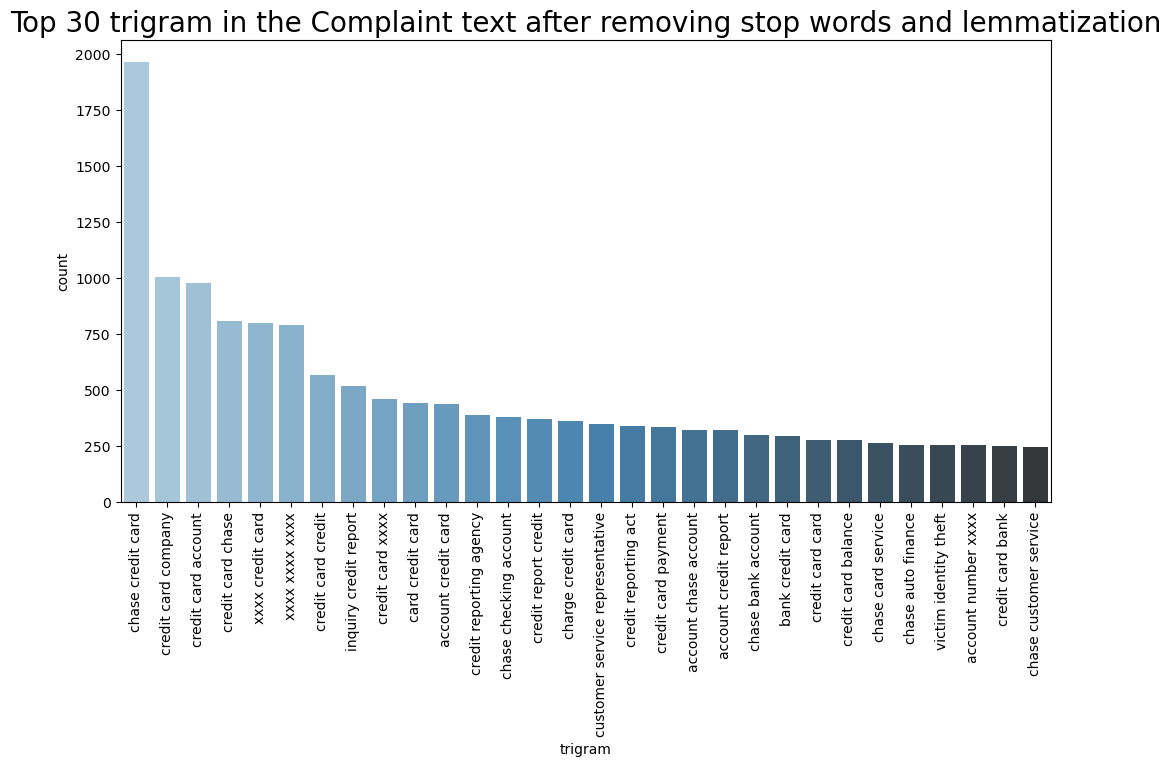

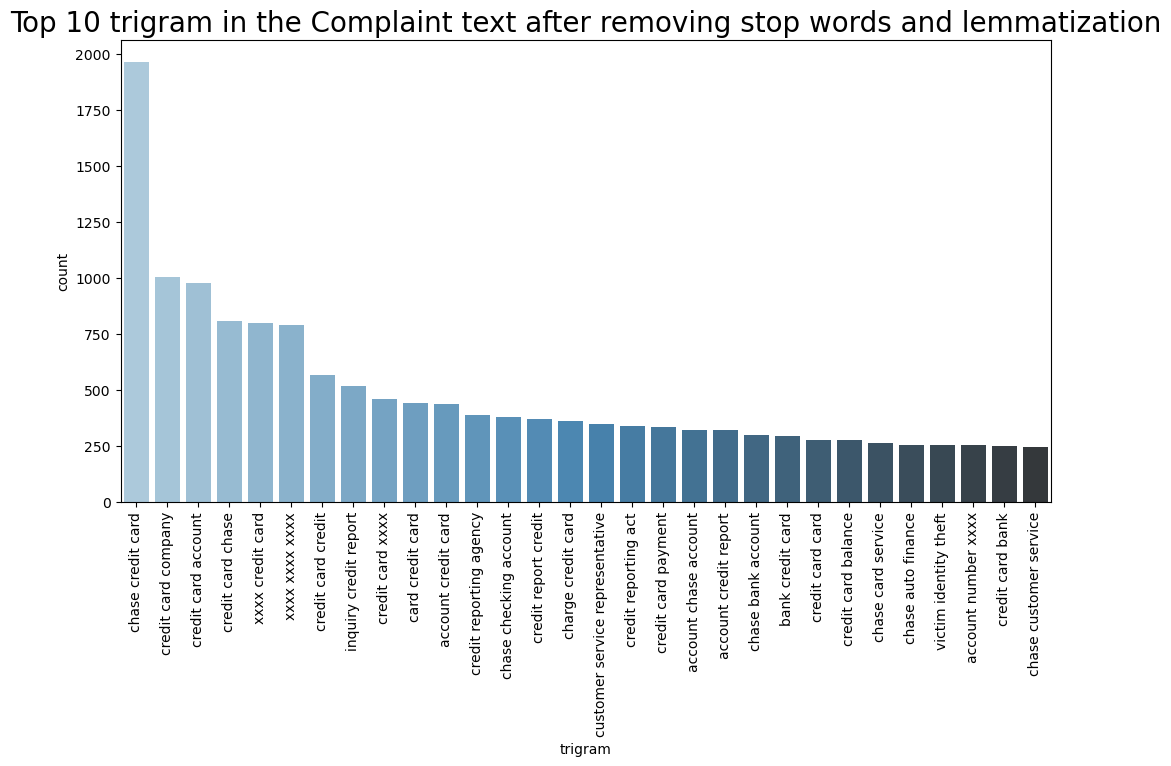

In [29]:
#Print the top 30 words in the trigram frequency
df_trigram = pd.DataFrame(top_30_trigrams[:30], columns = ['trigram' , 'count'])
display(df_trigram.head(30))

#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

create_ngram_barplot(top_30_trigrams, column='trigram', count=30)

create_ngram_barplot(top_30_trigrams, column='trigram', count=10)

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [30]:
def remove_xx(text):
    return re.sub(r'\s*\bx+\b\s*',' ',text)

df_clean['Complaint_clean'] = df_clean['Complaint_clean'].apply(remove_xx)

## Ngram after removing xxxx

,unigram,count
0,chase,53085
1,account,46176
2,credit,32599
3,card,30231
4,bank,21481
5,payment,21157
6,time,16002
7,day,12972
8,charge,11983
9,money,11955


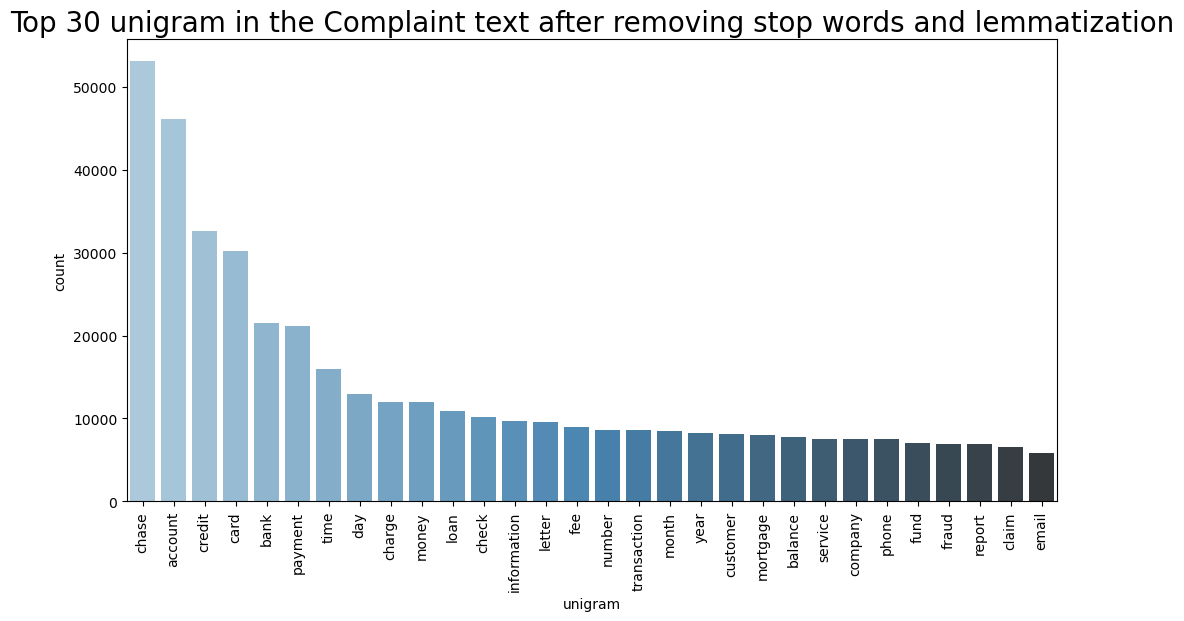

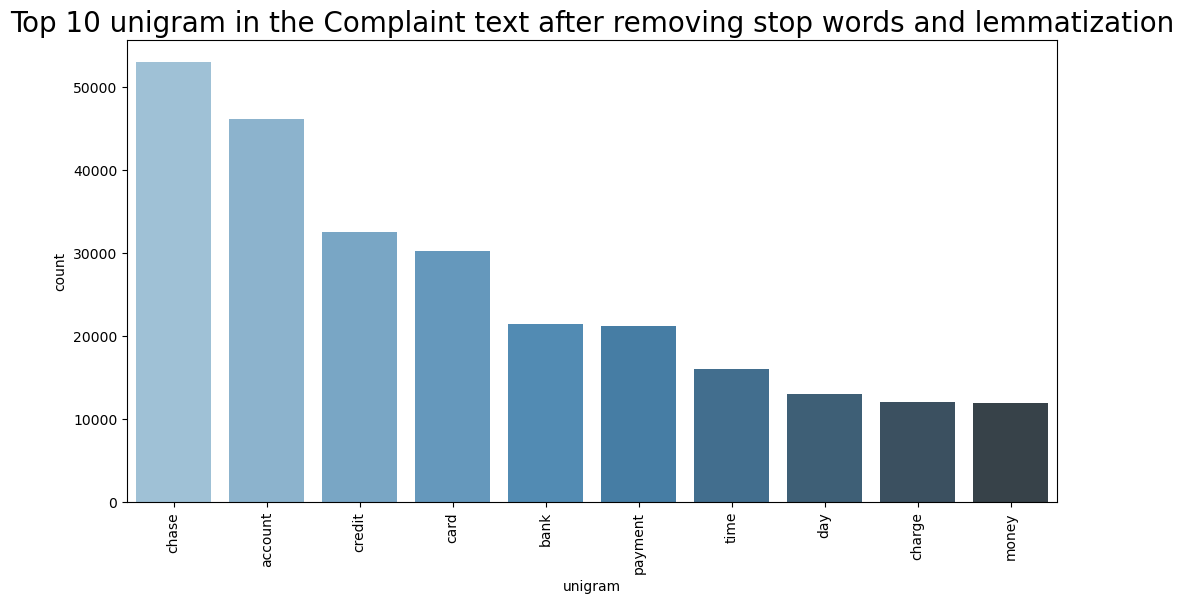

,bigram,count
0,credit card,12860
1,credit report,3846
2,account chase,3275
3,chase credit,3109
4,customer service,3065
5,chase account,3006
6,account account,2790
7,bank account,2540
8,chase bank,2127
9,debit card,1959


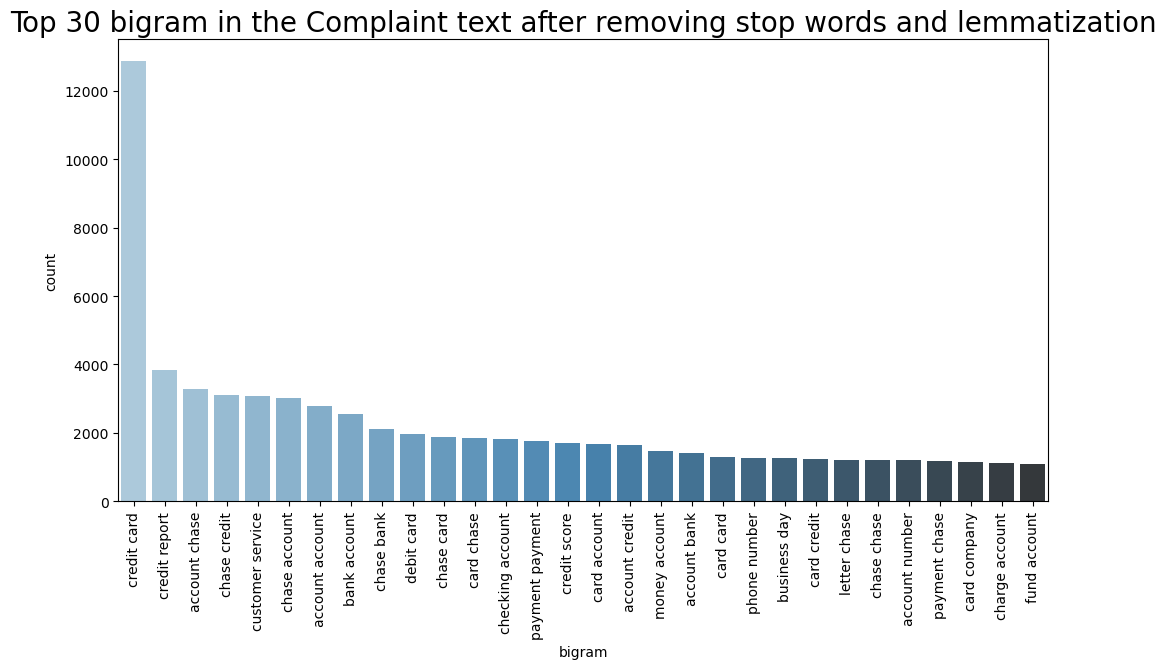

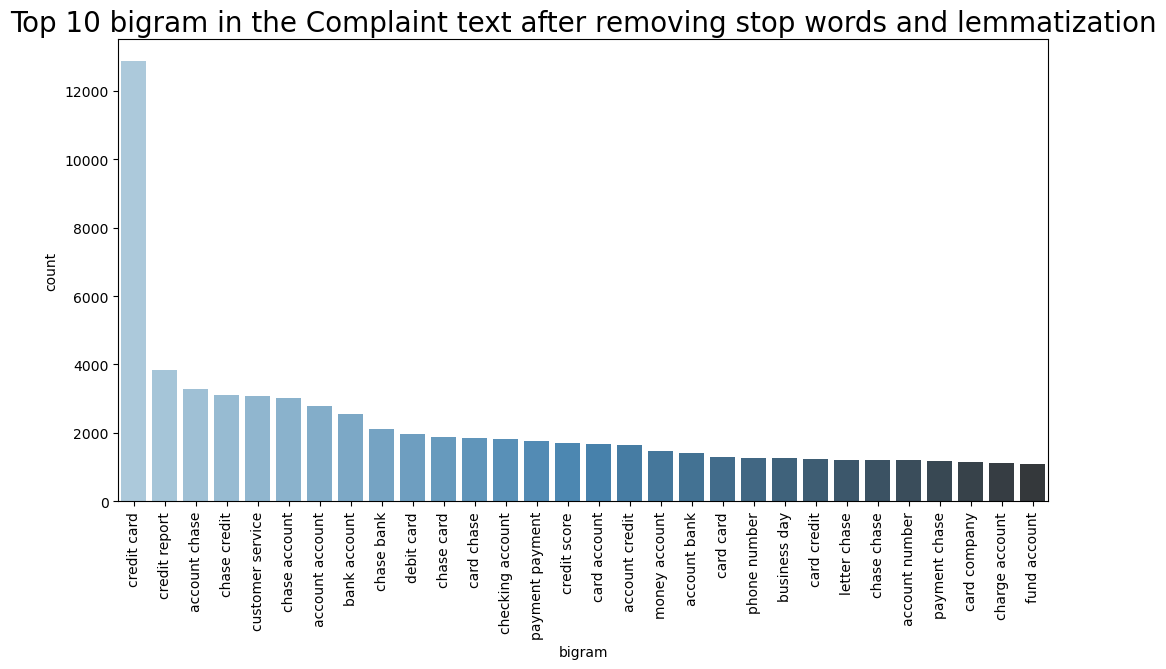

,trigram,count
0,chase credit card,2060
1,credit card company,1006
2,credit card account,1003
3,credit card chase,845
4,credit card credit,610
5,inquiry credit report,556
6,card credit card,488
7,account credit card,464
8,credit report credit,395
9,credit reporting agency,386


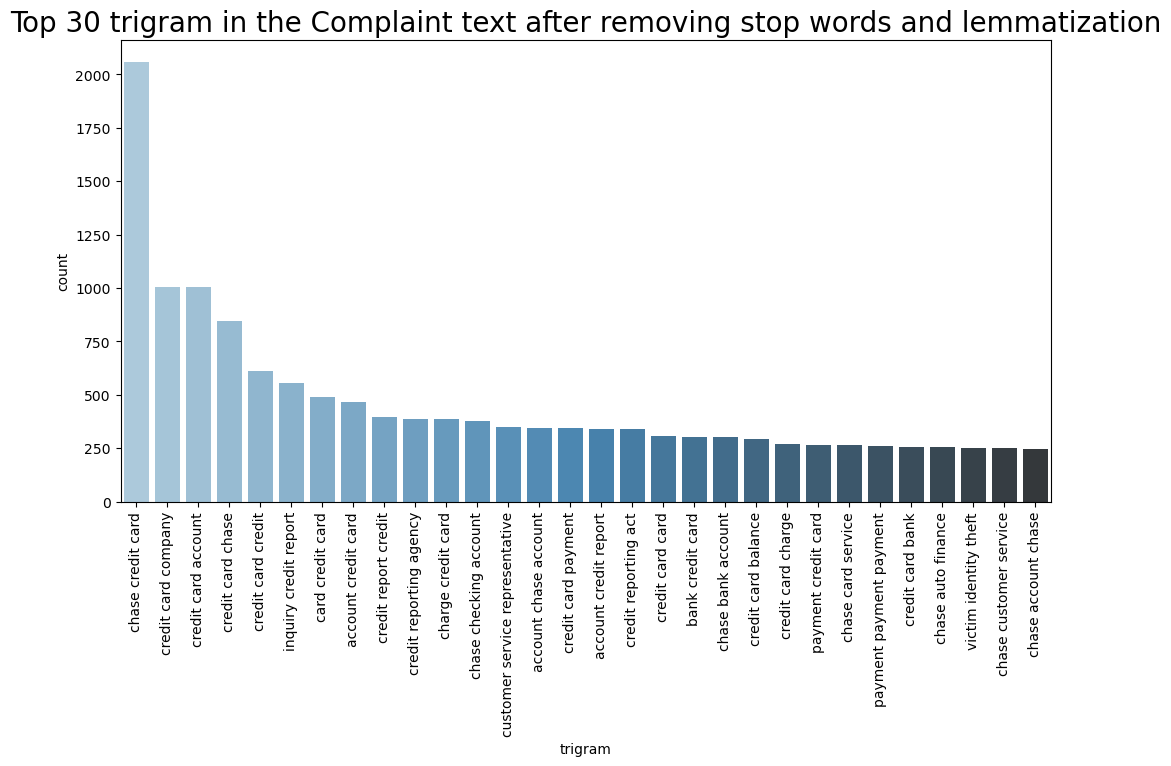

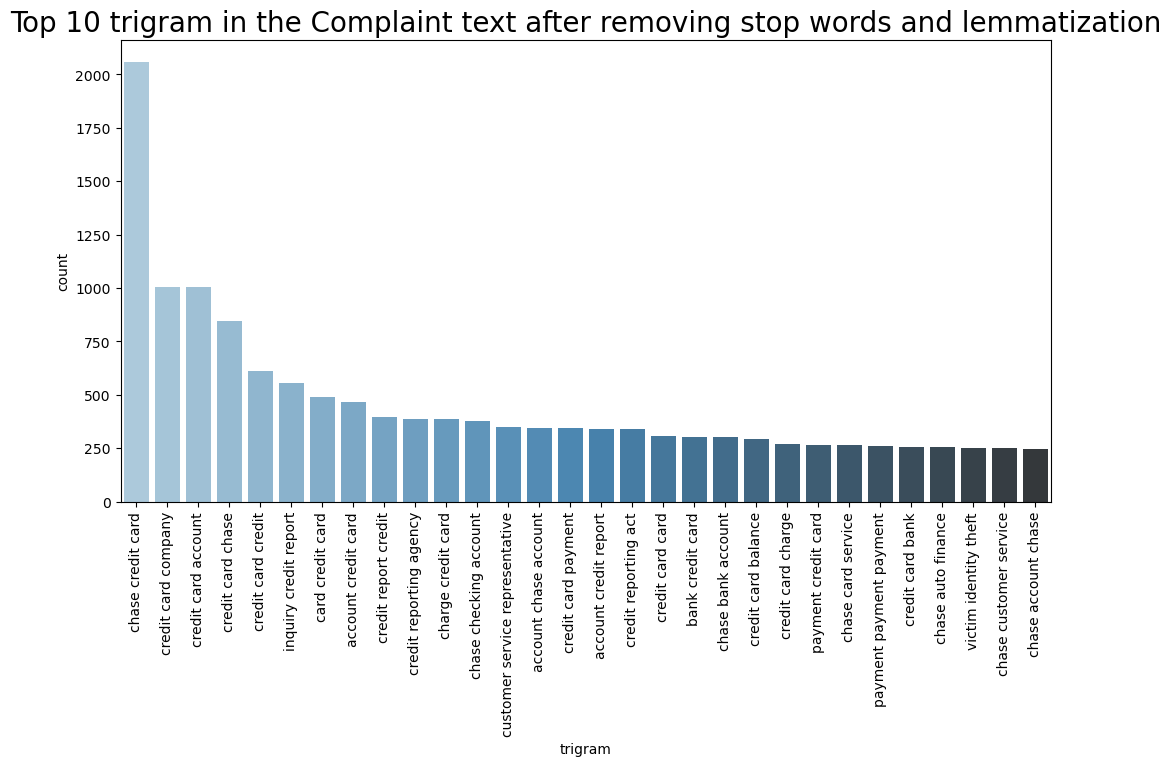

In [31]:
top_30_unigrams = get_top_ngram(df_clean.Complaint_clean,ngram=1, top=30)
top_30_bigrams = get_top_ngram(df_clean.Complaint_clean,ngram=2, top=30)
top_30_trigrams = get_top_ngram(df_clean.Complaint_clean,ngram=3, top=30)

top_10_unigrams = get_top_ngram(df_clean.Complaint_clean,ngram=1, top=10)
top_10_bigrams = get_top_ngram(df_clean.Complaint_clean,ngram=2, top=10)
top_10_trigrams = get_top_ngram(df_clean.Complaint_clean,ngram=3, top=10)

#Print the top 30 words in the unigram frequency
df_unigram = pd.DataFrame(top_30_unigrams[:30], columns = ['unigram' , 'count'])
display(df_unigram.head(30))

#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

create_ngram_barplot(top_30_unigrams, column='unigram', count=30)

create_ngram_barplot(top_10_unigrams, column='unigram', count=10)

#Print the top 30 words in the bigram frequency
df_bigram = pd.DataFrame(top_30_bigrams[:30], columns = ['bigram' , 'count'])
display(df_bigram.head(30))

#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

create_ngram_barplot(top_30_bigrams, column='bigram', count=30)

create_ngram_barplot(top_30_bigrams, column='bigram', count=10)

#Print the top 30 words in the trigram frequency
df_trigram = pd.DataFrame(top_30_trigrams[:30], columns = ['trigram' , 'count'])
display(df_trigram.head(30))

#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

create_ngram_barplot(top_30_trigrams, column='trigram', count=30)

create_ngram_barplot(top_30_trigrams, column='trigram', count=10)

In [32]:
#All masked texts has been removed
df_clean.head(10)

,complaints,lemmatized complaints,complaint_POS_removed,complaint_length,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account xxxx thank advance help,475,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx card agent anniversary date agent information order account anniversary date consent recording agent,337,card agent anniversary date agent information order account anniversary date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent service credit identity applicant,210,card application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now b

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [33]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(min_df=2,max_df=0.95,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [34]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [35]:
from sklearn.decomposition import NMF

# using gensim for automatic topic numbers
dataset = [d.split() for d in df_clean['Complaint_clean']]

dictionary = Dictionary(dataset)
dictionary.filter_extremes(no_below=3,no_above=0.95,keep_n=5000)
corpus = [dictionary.doc2bow(text) for text in dataset]
topic_nums = list(range(5,20,1))

coherence_scores = []


for num in topic_nums:
    nmf = Nmf(corpus=corpus , num_topics=num, id2word=dictionary,normalize=True,random_state=40)
    cm = CoherenceModel(model=nmf, texts=df_clean['Complaint_clean'],dictionary=dictionary,coherence='c_v') 
    coherence_scores.append(round(cm.get_coherence(),5))

scores = list(zip(topic_nums,coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]
print(best_num_topics)

5


In [36]:
df_clean.shape

(21072, 5)

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [37]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 

#keep the random_state =40
nmf_model = NMF(n_components=5, random_state=40)

In [38]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

6364

In [39]:
#Print the Top15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index+1}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #1
['customer', 'transaction', 'number', 'business', 'checking', 'fee', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']


THE TOP 15 WORDS FOR TOPIC #2
['reason', 'offer', 'service', 'point', 'purchase', 'month', 'year', 'score', 'limit', 'fee', 'account', 'balance', 'chase', 'credit', 'card']


THE TOP 15 WORDS FOR TOPIC #3
['day', 'fee', 'statement', 'property', 'balance', 'rate', 'year', 'time', 'modification', 'home', 'month', 'chase', 'mortgage', 'loan', 'payment']


THE TOP 15 WORDS FOR TOPIC #4
['file', 'proof', 'application', 'account', 'letter', 'theft', 'score', 'identity', 'debt', 'reporting', 'information', 'company', 'credit', 'report', 'inquiry']


THE TOP 15 WORDS FOR TOPIC #5
['company', 'phone', 'purchase', 'information', 'time', 'service', 'email', 'letter', 'merchant', 'fraud', 'claim', 'dispute', 'transaction', 'chase', 'charge']




In [40]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([0, 1, 1, ..., 4, 1, 2], dtype=int64)

In [41]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [42]:
df_clean.head(10)

,complaints,lemmatized complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account xxxx thank advance help,475,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account thank advance help,0
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx card agent anniversary date agent information order account anniversary date consent recording agent,337,card agent anniversary date agent information order account anniversary date consent recording agent,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent service credit identity applicant,210,card application identity consent service credit identity applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on t

In [43]:
df_clean.shape

(21072, 6)

In [44]:
#Print the first 5 Complaint for each of the Topics
df_clean_top_5=df_clean.groupby('Topic').head(5)
df_clean_top_5.sort_values('Topic')

,complaints,lemmatized complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account xxxx thank advance help,475,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account thank advance help,0
24,mishandling of this account by chase auto and xxxx,mishandle of this account by chase auto and xxxx,account chase auto xxxx,50,account chase auto,0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document this situation is truly affecting my livelihood and they dont seem to want to deal with me professionally thank you,with out notice jp morgan chase restrict my account by my debit card tuesday on thursday I go into a branch after be advise by a customer service representative that my account would actually be close I go into the branch to see how I can remove the fund that 

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [45]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [46]:
df_clean.head(10)

,complaints,lemmatized complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account xxxx thank advance help,475,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account thank advance help,Bank Account services
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx card agent anniversary date agent information order account anniversary date consent recording agent,337,card agent anniversary date agent information order account anniversary date consent recording agent,Credit card or prepaid card
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent service credit identity applicant,210,card application identity consent service credit identity applicant,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representa

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [47]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1, 
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [48]:
df_clean.head(10)

,complaints,lemmatized complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account xxxx thank advance help,475,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account thank advance help,0
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx card agent anniversary date agent information order account anniversary date consent recording agent,337,card agent anniversary date agent information order account anniversary date consent recording agent,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent service credit identity applicant,210,card application identity consent service credit identity applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on t

In [49]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["Complaint_clean","Topic"]]

In [50]:
training_data.head(10)

,Complaint_clean,Topic
1,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account thank advance help,0
2,card agent anniversary date agent information order account anniversary date consent recording agent,1
10,card application identity consent service credit identity applicant,1
11,ticket offer ticket reward card information offer minute screen decision bank chase bank notification screen representative application information offer credit offer account statement ticket account application representative application request application representative chase fact credit account name credit report chase information credit report application error,3
14,son check chase account fund chase bank account money son check money chase bank money son chase time check owner country time date check number claim number chase,0
15,inquiry,3
17,notice account debit card branch customer service representative account branch fund deposit place employment bank associate customer service representative fund business day branch fund post account fund statement business day date fund bank teller chase check business day fund account bind fee rent car payment notice thing peace mind fact chase situation bank teller account look chase right account time protocol past notice form document notice thing peace mind fact chase situation bank teller account look chase right account time protocol past notice form document situation livelihood,0
20,summer month decline income employment month payment extension auto loan company chase past four year request payment extension auto loan payment request month payment extension year situation supervisor avail discussion reason decline reason denial office communication representative chase week representative representative role matter representative conference call department request information request policy change explanation representative letter explanation letter reason denial policy change cfpb help denial payment extension request reason denial,2
21,payment retailer chase pay chase website scam website confirmation product response inquiry order chase information transaction refund retailer bank chase message way transaction contact information recipient message response email transfer website scam inquiry email expertise team order regard refund consumer support team number email situation claim department transaction chase information transfer agent call closing script contact number opportunity information question word phrase information system bank bank transaction menu customer service agent information transaction system bank transaction line understanding situation call chase chase time agent information bank information information situation claim department information nature transaction type transaction chase information recipient email address recipient banking information system phone call transaction responsibility regard matter process chase policy type transaction information situation transaction way money way business advertising way member customer service team,4
23,credit card datum credit report company issue,3


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vector to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [51]:

#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.Complaint_clean)

with open('count_vector_2.pkl', 'wb') as file:
    pickle.dump(count_vect.vocabulary_, file)


#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
with open('tfidf_2.pkl', 'wb') as file:
    pickle.dump(tfidf_transformer, file)


In [52]:
# Perform Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (15804, 14851)
Shape of y_train: (15804,)
Shape of X_test: (5268, 14851)
Shape of y_test: (5268,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [53]:
# Write your code here to build any 3 models and evaluate them using the required metrics



list(Topic_names.keys())

['Bank Account services',
 'Credit card or prepaid card',
 'Others',
 'Theft/Dispute Reporting',
 'Mortgage/Loan']

In [54]:
# Create a function to evaluate models
def eval_model(y_test, y_pred, model_name):
  
    print(f"Classification Report for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=list(Topic_names.keys())))
    
    
    return

### Model 1 - Logistic Regression

In [55]:
model_name = 'Logistic Regression'
clf_lr = LogisticRegression(solver='liblinear')
clf_lr.fit(X_train, y_train)

with open('logreg_model_1.pkl', 'wb') as file:
    pickle.dump(clf_lr, file)
    
y_pred_lr = clf_lr.predict(X_test)

In [56]:
# Calculate F1 Score of tuned model 
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
f1_lr

0.9495747575668737

In [57]:
# Run Logistic Regression on tuned hyperparameters
clf_lr_tuned = LogisticRegression(C=1, 
                                  penalty='l1', 
                                  solver='saga') 
clf_lr_tuned.fit(X_train, y_train)

with open('logreg_model_2_tuned.pkl', 'wb') as file:
    pickle.dump(clf_lr_tuned, file)


y_pred_lr_tuned = clf_lr_tuned.predict(X_test)

In [58]:
# Calculate F1 Score of tuned model using weighted average method
f1_lr_tuned = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr_tuned

0.9667943185647198

In [59]:
# Evaluate the tuned Logistic Regression classifier
eval_model(y_test, y_pred_lr_tuned, model_name)

Classification Report for Logistic Regression

                             precision    recall  f1-score   support

      Bank Account services       0.97      0.97      0.97      1315
Credit card or prepaid card       0.97      0.97      0.97      1041
                     Others       0.98      0.97      0.97      1285
    Theft/Dispute Reporting       0.97      0.95      0.96       516
              Mortgage/Loan       0.95      0.96      0.95      1111

                   accuracy                           0.97      5268
                  macro avg       0.97      0.96      0.97      5268
               weighted avg       0.97      0.97      0.97      5268



In [60]:
# Create a dataframe to store F1 Scores of all models we will build
summary = pd.DataFrame([{'Model': 'Logistic Regression','F1 Score (untuned)': round(f1_lr, 2), 'F1 Score (tuned)': round(f1_lr_tuned, 2)}])
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.95,0.97


### Model 2 - Decision Tree

In [61]:
# Run Decision Tree on default hyperparameters
model_name = 'Decision Tree'
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)

with open('DT_model.pkl', 'wb') as file:
    pickle.dump(clf_dt, file)


y_pred_dt = clf_dt.predict(X_test)

In [62]:
# Calculate F1 Score using weighted average method
f1_dt = f1_score(y_test, y_pred_dt, average="weighted")
f1_dt

0.8129974654631125

In [63]:
# Run Decision Tree on tuned hyperparameters
clf_dt_tuned = DecisionTreeClassifier(criterion='gini', 
                                      max_depth=30, 
                                      min_samples_leaf=15, 
                                      max_features=None)

clf_dt_tuned.fit(X_train, y_train)

with open('DT_model_tuned.pkl', 'wb') as file:
    pickle.dump(clf_dt_tuned, file)



y_pred_dt_tuned = clf_dt_tuned.predict(X_test)

In [64]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt_tuned = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt_tuned

0.8230433006358319

In [65]:
# Evaluate the tuned Decision Tree classifier
eval_model(y_test, y_pred_dt_tuned, model_name)

Classification Report for Decision Tree

                             precision    recall  f1-score   support

      Bank Account services       0.83      0.83      0.83      1315
Credit card or prepaid card       0.82      0.86      0.84      1041
                     Others       0.88      0.86      0.87      1285
    Theft/Dispute Reporting       0.84      0.77      0.80       516
              Mortgage/Loan       0.74      0.76      0.75      1111

                   accuracy                           0.82      5268
                  macro avg       0.82      0.82      0.82      5268
               weighted avg       0.82      0.82      0.82      5268



In [66]:
# Update the summary table
summary.loc[len(summary.index)] = ['Decision Tree', round(f1_dt, 2), round(f1_dt_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.95,0.97
1,Decision Tree,0.81,0.82


### Model 3 - Random Forest

In [67]:
model_name = 'Random Forest'
clf_rf = RandomForestClassifier()

clf_rf.fit(X_train, y_train)


with open('RF_model.pkl', 'wb') as file:
    pickle.dump(clf_rf, file)

y_pred_rf = clf_rf.predict(X_test)

In [68]:
# Calculate F1 Score using weighted average method
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
f1_rf

0.855431315788272

In [69]:
# Run Random Forest on tuned hyperparameters
clf_rf_tuned = RandomForestClassifier(n_estimators=100, 
                                      min_samples_split=5, 
                                      min_samples_leaf=5, 
                                      max_features=None, 
                                      max_depth=30, 
                                      criterion='gini'
)

clf_rf_tuned.fit(X_train, y_train)

with open('RF_model_tuned.pkl', 'wb') as file:
    pickle.dump(clf_rf_tuned, file)


y_pred_rf_tuned = clf_rf_tuned.predict(X_test)

In [70]:
# Calculate F1 Score of tuned model using weighted average method
f1_rf_tuned = f1_score(y_test, y_pred_rf_tuned, average="weighted")
f1_rf_tuned

0.8735413515731661

In [71]:
# Evaluate the tuned Random Forest classifier
eval_model(y_test, y_pred_rf_tuned, model_name)

Classification Report for Random Forest

                             precision    recall  f1-score   support

      Bank Account services       0.88      0.87      0.88      1315
Credit card or prepaid card       0.88      0.90      0.89      1041
                     Others       0.90      0.91      0.91      1285
    Theft/Dispute Reporting       0.87      0.83      0.85       516
              Mortgage/Loan       0.83      0.82      0.83      1111

                   accuracy                           0.87      5268
                  macro avg       0.87      0.87      0.87      5268
               weighted avg       0.87      0.87      0.87      5268



In [72]:
# Update the summary table
summary.loc[len(summary.index)] = ['Random Forest', round(f1_rf, 2), round(f1_rf_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.95,0.97
1,Decision Tree,0.81,0.82
2,Random Forest,0.86,0.87


### Model 4 - Naive Bayes

In [73]:
model_name = 'Naive Bayes'
clf_nb = MultinomialNB()
clf_nb.fit(X_train, y_train)


with open('NB_model.pkl', 'wb') as file:
    pickle.dump(clf_nb, file)


y_pred_nb = clf_nb.predict(X_test)

In [74]:
# Calculate F1 Score using weighted average method
f1_nb = f1_score(y_test, y_pred_nb, average="weighted")
f1_nb

0.7527468776025923

In [75]:
# Run Multinomial Naive Bayes on tuned hyperparameters
clf_nb_tuned = MultinomialNB(alpha=0.1, fit_prior=False)
clf_nb_tuned.fit(X_train, y_train)

with open('NB_model_tuned.pkl', 'wb') as file:
    pickle.dump(clf_nb_tuned, file)

y_pred_nb_tuned = clf_nb_tuned.predict(X_test)

In [76]:
# Calculate F1 Score of tuned model using weighted average method
f1_nb_tuned = f1_score(y_test, y_pred_nb_tuned, average="weighted")
f1_nb_tuned

0.7785481863953879

In [77]:
# Evaluate the tuned Naive Bayes classifier
eval_model(y_test, y_pred_nb_tuned, model_name)

Classification Report for Naive Bayes

                             precision    recall  f1-score   support

      Bank Account services       0.82      0.82      0.82      1315
Credit card or prepaid card       0.72      0.69      0.71      1041
                     Others       0.85      0.82      0.83      1285
    Theft/Dispute Reporting       0.68      0.81      0.74       516
              Mortgage/Loan       0.77      0.74      0.75      1111

                   accuracy                           0.78      5268
                  macro avg       0.76      0.78      0.77      5268
               weighted avg       0.78      0.78      0.78      5268



## Summary

In [78]:
# Update the summary table
summary.loc[len(summary.index)] = ['Naive Bayes', round(f1_nb, 2), round(f1_nb_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.95,0.97
1,Decision Tree,0.81,0.82
2,Random Forest,0.86,0.87
3,Naive Bayes,0.75,0.78


### Logistic regression is the best model


# Model Predict - topics via Logistic Regression on custom text


In [79]:
# Function to predict a topic for custom text

target_names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

load_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector_2.pkl", "rb")))
load_tfidf = pickle.load(open("tfidf_2.pkl","rb"))
load_model = pickle.load(open("logreg_model_2_tuned.pkl","rb"))

def topic_predictor(text):
    

    X_new_count = load_vec.transform(text)
    X_new_tfidf = load_tfidf.transform(X_new_count)
    prediction = load_model.predict(X_new_tfidf)

    return target_names[prediction[0]]



In [80]:

banking_comments = [
    "I'm having trouble accessing my online banking account. Can you assist me with resetting my password?",
    "I received a suspicious email claiming to be from the bank. Could you verify if it's legitimate?",
    "I need to update my contact information for account notifications. How can I do that?",
    "I've lost my debit card and need to report it lost or stolen. What steps should I take?",
    "I'd like to inquire about the current interest rates for a new savings account.",
    "There's an unauthorized transaction on my account. Can you help me dispute it?",
    "I'm interested in applying for a personal loan. What documents do I need to provide?",
    "I'm experiencing issues with mobile banking app. It's not loading properly. Can you assist?",
    "I want to set up automatic bill payments for my utilities. How can I do that through online banking?",
    "I've noticed some unusual charges on my credit card statement. Can you investigate?",
    "I need to transfer funds between my accounts. How long does it usually take to process?",
    "I'm having difficulty understanding some of the fees on my account. Can you explain them to me?",
    "My credit card was declined during a purchase. Can you check if there's an issue with my account?",
    "I want to update my mailing address for bank statements. How can I do that?",
    "I'd like to request a higher credit limit on my card. What's the process for doing so?",
    "I'm planning to travel abroad. Do I need to notify the bank to avoid any issues with my card?",
    "I'm a victim of identity theft and need assistance securing my accounts. What should I do?",
    "I'm interested in opening a joint account with my spouse. What are the requirements?",
    "I've received a check from a friend. Can I deposit it using the mobile banking app?",
    "I've forgotten my security questions for online banking. Is there a way to reset them?",
    "I want to close my account. What are the steps involved in doing so?",
    "I'm considering switching banks. What factors should I consider before making a decision?",
    "I've applied for a mortgage and haven't received a response yet. Can you check the status?",
    "I'd like to enroll in paperless statements to reduce paper waste. How can I do that?",
    "I'm a new customer and have questions about the benefits of different account types. Can you help?",
    "I've received a phishing email pretending to be from the bank. What should I do with it?",
    "I'm interested in setting up a savings goal. Is there a feature for that in online banking?",
    "I want to change the PIN for my debit card. How can I do that?",
    "I'm planning to buy a house and need advice on the best mortgage options available.",
    "I've lost my credit card while traveling abroad. What should I do to prevent fraud?",
    "I've noticed a discrepancy in my account balance. Can you help me reconcile it?",
    "I need to update my beneficiary information for my accounts. How can I do that?",
    "I'm experiencing technical issues with the ATM. Can you troubleshoot the problem?",
    "I want to set up account alerts for large transactions. How can I do that?",
    "I'm interested in refinancing my student loans. What options are available?",
    "I need to order new checks for my checking account. How can I do that?",
    "I'm planning to retire soon and need advice on managing my retirement savings.",
    "I've received a suspicious text message asking for my account details. Is it a scam?",
    "I want to dispute a charge on my credit card. What's the process for initiating a dispute?",
    "I'm interested in opening a custodial account for my child. What are the requirements?",
    "I need assistance setting up direct deposit for my paycheck. Can you help me with that?",
    "I'm interested in investing in mutual funds. Can you provide information on available options?",
    "I want to set up a budgeting tool to track my expenses. Does the bank offer such a feature?",
    "I've noticed an error on my credit report. What steps should I take to correct it?",
    "I'm planning to make a large purchase and want to ensure my card has sufficient funds.",
    "I've received a notice about an overdraft fee. Can you waive it for me?",
    "I want to set up a recurring transfer between my accounts. How can I schedule that?",
    "I'm experiencing issues with the online bill payment service. Can you assist me?",
    "I've received a refund for a canceled transaction. When will the funds be available in my account?",
    "I'm interested in applying for a business loan. What documents do I need to provide?",
    "I've received a tax refund and want to deposit it into my savings account. Can you assist?",
    "I want to redeem my credit card rewards. How can I do that?",
    "I'm planning to buy a car and need financing options. Can you provide information on auto loans?",
    "I've noticed an error in my account statement. Can you help me correct it?",
    "I need to update my email address for account notifications. How can I do that?",
    "I've received a letter about an account closure. Can you provide more information?",
    "I'm interested in setting up a retirement account. What are the different options available?",
    "I want to dispute a transaction on my debit card. Can you assist me with the process?",
    "I'm planning to travel internationally and want to ensure my card will work abroad.",
    "I've received a notice about changes to my account terms. Can you explain the updates?",
    "I want to open a college savings account for my child. What options are available?",
    "I'm interested in setting up automatic transfers to my savings account. How can I do that?",
    "I've received a notice about an upcoming fee increase. Can you provide more information?",
    "I need assistance with setting up online banking on my mobile device. Can you guide me?",
    "I'm interested in setting up a certificate of deposit (CD) account. What are the rates?",
    "I want to add a beneficiary to my life insurance policy. How can I update the information?",
    "I've received a notice about an expiring credit card. Can you assist with issuing a new one?",
    "I'm planning to move abroad temporarily and want to ensure my accounts remain accessible.",
    "I've received an email about a security breach. Can you provide guidance on next steps?",
    "I want to set up a savings plan for a specific financial goal. How can I do that?",
    "I'm interested in setting up a trust account. What documentation is required?",
    "I've received a notice about changes to account fees. Can you provide more details?",
    "I want to set up account notifications for suspicious activity. How can I enable this feature?",
    "I'm experiencing issues with the bank's website. Can you check if there's an outage?",
    "I've received a notice about changes to the bank's privacy policy. Can you explain the updates?",
    "I want to add a joint account holder to my existing account. What documents are needed?",
    "I'm interested in setting up automatic transfers to my retirement account. How can I do that?",
    "I've received a notice about changes to account terms and conditions. Can you clarify?",
    "I need assistance with setting up online bill payment for my utilities. Can you help me?",
    "I'm interested in setting up a health savings account (HSA). What are the benefits?",
    "I've received a notice about an upcoming maintenance outage. Can you provide more information?",
    "I want to close my credit card account. What steps are involved in the process?",
    "I'm planning to buy a home and need assistance with a mortgage pre-approval. Can you help?",
    "I've received a notice about changes to the bank's hours of operation. Can you confirm?",
    "I need to update my account information for tax purposes. How can I do that?",
    "I'm interested in setting up a recurring donation to a charity. Can you assist with that?",
    "I've received a notice about an increase in overdraft fees. Can you explain the reason?",
    "I want to change my overdraft protection settings. How can I make the adjustment?",
    "I'm planning to retire soon and need guidance on withdrawing funds from my retirement account.",
    "I've received a notice about changes to account overdraft policies. Can you provide more details?",
    "I need assistance with setting up online statements for my account. Can you guide me through?",
    "I'm interested in setting up a custodial brokerage account for my child. What are the options?",
    "I've received a notice about changes to account minimum balance requirements. Can you clarify?",
    "I want to cancel a recurring transfer between my accounts. How can I cancel it?",
    "I'm experiencing issues with the bank's mobile app. Can you troubleshoot the problem?",
    "I've received a notice about an increase in ATM withdrawal fees. Can you explain the change?",
    "I need assistance with setting up automatic bill payment for my credit card. Can you assist?",
    "I'm interested in setting up a college fund for my child. What are the available options?",
    "I've received a notice about changes to account maintenance fees. Can you provide more information?",
    "I want to transfer funds to an international bank account. What's the process for doing so?",
    "I'm experiencing issues with the bank's telephone banking service. Can you assist with troubleshooting?",
    "I've received a notice about changes to account transaction limits. Can you explain the updates?",
    "I need assistance with setting up online transfers between my accounts. Can you help me?",
    "I'm interested in setting up a custodial IRA for my child. What documentation is required?",
    "I've received a notice about changes to account statement delivery options. Can you clarify?",
    "I want to dispute a charge on my debit card that I didn't authorize. Can you assist?",
    "I'm experiencing issues with the bank's online chat support. Can you assist with troubleshooting?",
    "I've received a notice about changes to account debit card replacement fees. Can you explain?",
    "I need assistance with setting up online access for a new account. Can you guide me through?",
    "I'm interested in setting up a trust fund for my grandchildren. What are the available options?",
    "I've received a notice about changes to account wire transfer fees. Can you provide more information?",
    "I want to cancel a scheduled bill payment. How can I cancel it before it's processed?",
    "I'm experiencing issues with the bank's online account login page. Can you assist with troubleshooting?",
    "I've received a notice about changes to account online security features. Can you clarify?",
    "I need assistance with setting up online bill pay for my mortgage. Can you help me?",
    "I'm interested in setting up a custodial investment account for my child. What are the options?",
    "I've received a notice about changes to account check printing fees. Can you explain the updates?",
    "I want to update my account preferences for receiving promotional offers. How can I do that?",
    "I'm experiencing issues with the bank's online account balance display. Can you assist with troubleshooting?",
    "I've received a notice about changes to account paper statement fees. Can you provide more information?",
    "I need assistance with setting up automatic transfers to my savings account. Can you help me?",
    "I'm interested in setting up a custodial 529 plan for my child. What are the available options?",
    "I've received a notice about changes to account international wire transfer fees. Can you explain?",
    "I want to close an account that I no longer use. What steps are involved in the process?",
    "I'm experiencing issues with the bank's mobile check deposit feature. Can you assist with troubleshooting?",
    "I've received a notice about changes to account online bill payment fees. Can you provide more information?",
    "I need assistance with setting up automatic transfers to my retirement account. Can you help me?",
    "I'm interested in setting up a custodial UTMA account for my child. What are the options?",
    "I've received a notice about changes to account overdraft protection transfer fees. Can you explain?",
    "I want to change the beneficiary designation for my retirement account. How can I do that?",
    "I'm experiencing issues with the bank's online account transaction history. Can you assist with troubleshooting?",
    "I've received a notice about changes to account incoming wire transfer fees. Can you provide more information?",
    "I need assistance with setting up online transfers between my accounts. Can you help me?",
    "I'm interested in setting up a custodial UGMA account for my child. What are the options?",
    "I've received a notice about changes to account outgoing wire transfer fees. Can you explain?",
    "I want to dispute a charge on my debit card that I didn't authorize. Can you assist?",
    "I'm experiencing issues with the bank's online chat support. Can you assist with troubleshooting?",
    "I've received a notice about changes to account debit card replacement fees. Can you explain?",
    "I need assistance with setting up online access for a new account. Can you guide me through?",
    "I'm interested in setting up a trust fund for my grandchildren. What are the available options?",
    "I've received a notice about changes to account wire transfer fees. Can you provide more information?",
    "I want to cancel a scheduled bill payment. How can I cancel it before it's processed?",
    "I'm experiencing issues with the bank's online account login page. Can you assist with troubleshooting?",
    "I've received a notice about changes to account online security features. Can you clarify?",
    "I need assistance with setting up online bill pay for my mortgage. Can you help me?",
    "I'm interested in setting up a custodial investment account for my child. What are the options?",
    "I've received a notice about changes to account check printing fees. Can you explain the updates?",
    "I want to update my account preferences for receiving promotional offers. How can I do that?",
    "I'm experiencing issues with the bank's online account balance display. Can you assist with troubleshooting?",
    "I've received a notice about changes to account paper statement fees. Can you provide more information?",
    "I need assistance with setting up automatic transfers to my savings account. Can you help me?",
    "I'm interested in setting up a custodial 529 plan for my child. What are the available options?",
    "I've received a notice about changes to account international wire transfer fees. Can you explain?",
    "I want to close an account that I no longer use. What steps are involved in the process?",
    "I'm experiencing issues with the bank's mobile check deposit feature. Can you assist with troubleshooting?",
    "I've received a notice about changes to account online bill payment fees. Can you provide more information?",
    "I need assistance with setting up automatic transfers to my retirement account. Can you help me?",
    "I'm interested in setting up a custodial UTMA account for my child. What are the options?",
    "I've received a notice about changes to account overdraft protection transfer fees. Can you explain?",
    "I want to change the beneficiary designation for my retirement account. How can I do that?",
    "I'm experiencing issues with the bank's online account transaction history. Can you assist with troubleshooting?",
    "I've received a notice about changes to account incoming wire transfer fees. Can you provide more information?"
]

In [81]:

# Create a dataframe of some sample customer complaints
df_custom = pd.DataFrame({'complaints':banking_comments})


In [82]:
# Load the object from the pickle file
loaded_object = pickle.load(open("count_vector_2.pkl", "rb"))

# Print the type of the loaded object
print(type(loaded_object))


<class 'dict'>


In [83]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_custom['predicted topic'] = df_custom['complaints'].apply(lambda x: topic_predictor([x]))
df_custom.head(10)

,complaints,predicted topic
0,I'm having trouble accessing my online banking account. Can you assist me with resetting my password?,Bank Account services
1,I received a suspicious email claiming to be from the bank. Could you verify if it's legitimate?,Mortgage/Loan
2,I need to update my contact information for account notifications. How can I do that?,Bank Account services
3,I've lost my debit card and need to report it lost or stolen. What steps should I take?,Theft/Dispute Reporting
4,I'd like to inquire about the current interest rates for a new savings account.,Bank Account services
5,There's an unauthorized transaction on my account. Can you help me dispute it?,Mortgage/Loan
6,I'm interested in applying for a personal loan. What documents do I need to provide?,Others
7,I'm experiencing issues with mobile banking app. It's not loading properly. Can you assist?,Mortgage/Loan
8,I want to set up automatic bill payments for my utilities. How can I do that through online banking?,Mortgage/Loan
9,I've noticed some unusual charges on my credit card statement. Can you investigate?,Credit card or prepaid card


In [84]:
topic_predictor([df_custom['complaints'][0]])

'Bank Account services'

In [85]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
import pickle

class TopicPredictor:
    def __init__(self, count_vector_path, tfidf_path, model_path):
        self.target_names = [
            "Bank Account services",
            "Credit card or prepaid card",
            "Others",
            "Theft/Dispute Reporting",
            "Mortgage/Loan"
        ]
        self.load_vectorizer(count_vector_path)
        self.load_tfidf(tfidf_path)
        self.load_model(model_path)

    def load_vectorizer(self, path):
        self.vectorizer = CountVectorizer(vocabulary=pickle.load(open(path, "rb")))

    def load_tfidf(self, path):
        self.tfidf = pickle.load(open(path, "rb"))

    def load_model(self, path):
        self.model = pickle.load(open(path, "rb"))

    def predict_topic(self, text):
        X_new_count = self.vectorizer.transform(text)
        X_new_tfidf = self.tfidf.transform(X_new_count)
        prediction = self.model.predict(X_new_tfidf)
        return self.target_names[prediction[0]]

# Example usage
if __name__ == "__main__":
    predictor = TopicPredictor("count_vector_2.pkl", "tfidf_2.pkl", "logreg_model_2_tuned.pkl")
    input_text = banking_comments[0]
    predicted_topic = predictor.predict_topic([input_text])
    print(f"Predicted topic: {predicted_topic}")

Predicted topic: Bank Account services
